In [1]:
import json
import re
import csv
from langdetect import detect
import nltk
import os
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from textblob import TextBlob
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from pathlib import Path

In [2]:
data_directory = '../data/'

# Load the json files from the data directory
files = os.listdir(data_directory)
json_files = [f for f in files if f.endswith('.json')]

In [3]:
def clean_text(text):
    # Remove emojis, special symbols, and extra whitespaces
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # Remove leading and trailing whitespaces
    cleaned_text = cleaned_text.strip()
    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    return cleaned_text


def tokenize_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    return tokens


def remove_stopwords(tokens):
    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens


def lemmatize_tokens(tokens):
    # Lemmatize the tokens
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

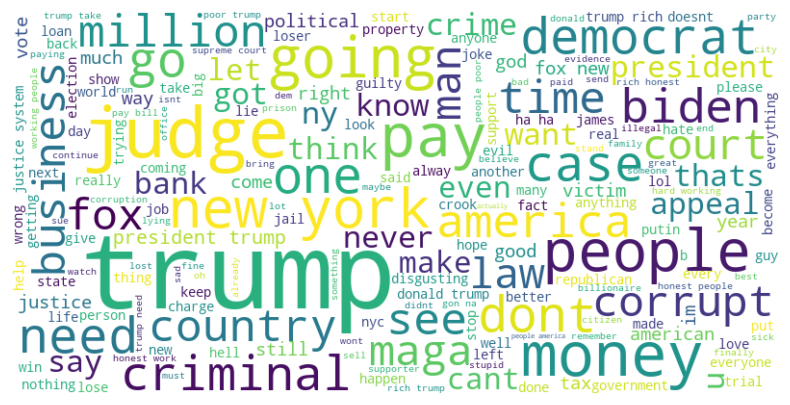

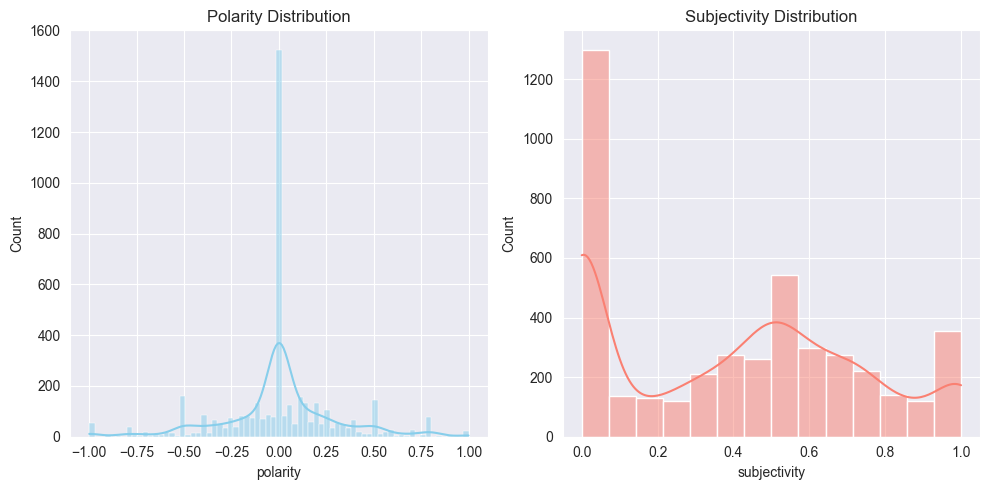

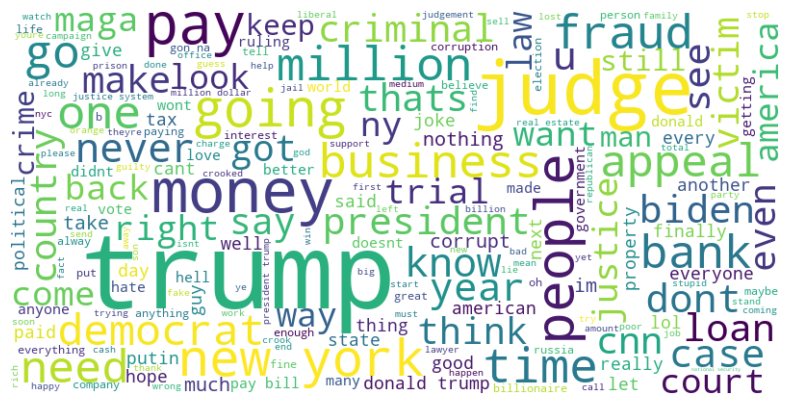

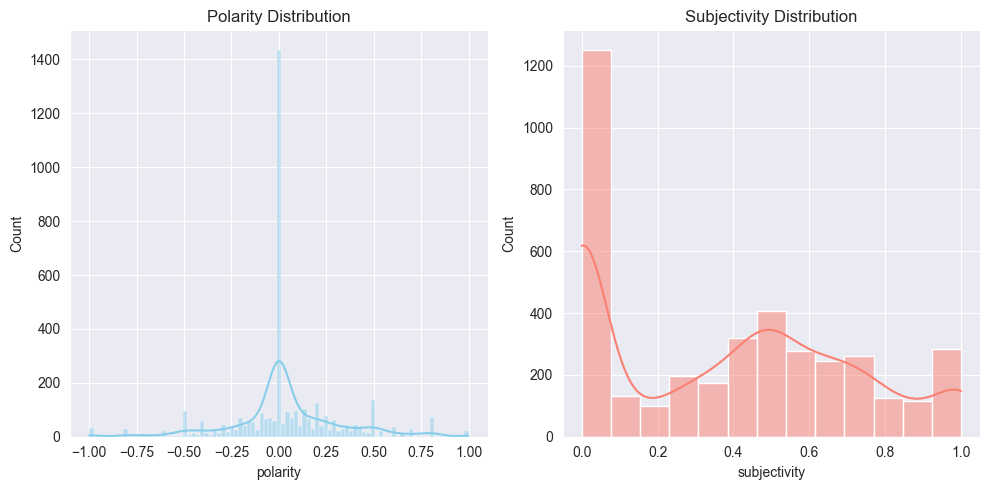

In [4]:
for json_file in json_files:
    with open(data_directory + json_file, 'r') as f:
        data = json.load(f)
    comments = data['video_comments']
    cleaned_comments = []
    for comment in comments:
        comment_text = comment['comment_text']
        try:
            lang = detect(comment_text)
            if lang == 'en':
                cleaned_comment = clean_text(comment_text)
                cleaned_comments.append(cleaned_comment)
        except:
            # If language detection fails, skip the comment
            pass

    # Save cleaned comments to a new CSV file, add a header
    with open("../preprocessed_data/{}-cleaned.csv".format(json_file.split('.')[0]), 'w', newline='') as cleaned_csv_file:
        writer = csv.writer(cleaned_csv_file)
        writer.writerow(['comment'])
        for comment in cleaned_comments:
            writer.writerow([comment])
            
    tokenized_comments = []
    for comment in cleaned_comments:
        tokens = tokenize_text(comment)
        tokens = remove_stopwords(tokens)
        tokens = lemmatize_tokens(tokens)
        tokenized_comments.append(tokens)
        
    # Save tokenized comments to a new CSV file
    with open("../preprocessed_data/{}-tokenized.csv".format(json_file.split('.')[0]), 'w', newline='') as tokenized_csv_file:
        writer = csv.writer(tokenized_csv_file)
        for tokens in tokenized_comments:
            writer.writerow(tokens)
            
    # Flatten the list of lists
    flat_list = [item for sublist in tokenized_comments for item in sublist]
    
    # Convert the list to a string
    text = ' '.join(flat_list)
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white',
                          stopwords=STOPWORDS).generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
    # Save the word cloud to an image file
    if not os.path.exists('../images'):
        os.makedirs('../images')
        
    wordcloud.to_file("../images/{}-wordcloud.png".format(json_file.split('.')[0]))
    
    comments = pd.read_csv('../preprocessed_data/{}-cleaned.csv'.format(json_file.split('.')[0]))
    comments['polarity'] = comments['comment'].apply(lambda x: TextBlob(x).sentiment.polarity)
    comments['subjectivity'] = comments['comment'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    # Plot the distribution of polarity and subjectivity
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(comments['polarity'], kde=True, color='skyblue')
    plt.title('Polarity Distribution')
    plt.subplot(1, 2, 2)
    sns.histplot(comments['subjectivity'], kde=True, color='salmon')
    plt.title('Subjectivity Distribution')
    plt.tight_layout()
    # Save the plot
    if not os.path.exists('../images'):
        os.makedirs('../images')
    plt.savefig('../images/{}-sentiment_distribution.png'.format(json_file.split('.')[0]))
    plt.show()